# Model for Cat Dog Classifier

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.image as mpimg

%matplotlib inline

In [ ]:
downloaded = drive.CreateFile({'id':"replae with your id"})   # replace the id with id of file you want to access
downloaded.GetContentFile('your_file_name')


In [ ]:
!unzip /content/cats-dog.zip

# Importing the Dataset and Preprocessing

In [ ]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "cats_vs_dogs.h5"

# Data
path = "/content/cats-dogs/"
training_data_dir = path + "training" # 10 000 * 2
validation_data_dir = path + "validation" # 2 500 * 2
test_data_dir = path + "testi" # 12 500

In [ ]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [42]:

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


# Creating the Model

In [54]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation="relu", padding="same"))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation="relu", padding="same"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        return model
        
    model = tf.keras.models.Sequential()
    
    model.add(Input(shape = (200, 200, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model.add(Flatten())
    
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    
    model.compile(loss='binary_crossentropy',
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])



    return model

model_sample = create_model()
model_sample.summary()
    

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 100, 100, 64)     

In [43]:
CHECKPOINT_FILE_PATH = '/content/models/{}_checkpoint.h5'.format('model')
checkpoint = ModelCheckpoint(CHECKPOINT_FILE_PATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)

# Training the Model

In [ ]:
%%time


# Training
h = model_sample.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[ checkpoint], 
    verbose=1)
model.save_weights(model_sample)

In [ ]:
model_sample.save_weights('/content/models/')

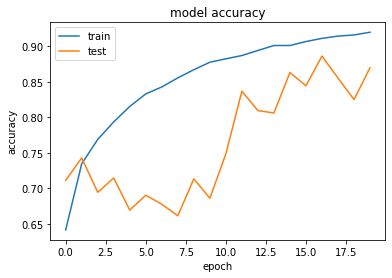

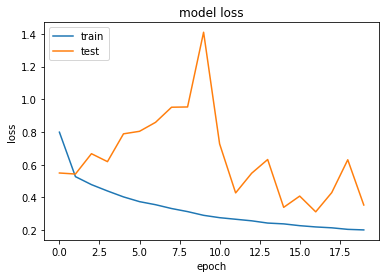

In [59]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predicting from the model

In [ ]:
# Testing
import matplotlib.image as mpimg
probabilities = model_sample.predict(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

# Creating a second model with Adam Optimizer

In [ ]:
def create_model_2():
    
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation="relu", padding="same"))
        model.add(Conv2D(num_filters, 3, activation="relu", padding="same"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        return model
        
    model = tf.keras.models.Sequential()
    
    model.add(Input(shape = (200, 200, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model = add_conv_block(model, 256)
    model.add(Flatten())
    
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    
    model.compile(loss='binary_crossentropy',
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])



    return model

    

In [65]:
model_2 = create_model_2()
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 50, 50, 64)       

In [80]:
%%time


# Training
h2 = model_2.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('/content/models/model_{epoch}_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')], 
    verbose=1)

Epoch 1/20
625/625 [==============================] - 299s 478ms/step - loss: 0.6425 - accuracy: 0.6073 - val_loss: 0.5672 - val_accuracy: 0.6953
Epoch 2/20
625/625 [==============================] - 295s 473ms/step - loss: 0.5470 - accuracy: 0.7189 - val_loss: 0.5241 - val_accuracy: 0.7318
Epoch 3/20
625/625 [==============================] - 292s 467ms/step - loss: 0.4961 - accuracy: 0.7562 - val_loss: 0.5324 - val_accuracy: 0.7510
Epoch 4/20
625/625 [==============================] - 292s 466ms/step - loss: 0.4372 - accuracy: 0.7964 - val_loss: 0.4866 - val_accuracy: 0.7792
Epoch 5/20
625/625 [==============================] - 291s 465ms/step - loss: 0.3968 - accuracy: 0.8214 - val_loss: 0.4009 - val_accuracy: 0.8151
Epoch 6/20
625/625 [==============================] - 290s 463ms/step - loss: 0.3499 - accuracy: 0.8444 - val_loss: 0.3479 - val_accuracy: 0.8498
Epoch 7/20
625/625 [==============================] - 292s 468ms/step - loss: 0.3236 - accuracy: 0.8575 - val_loss: 0.3127 -

In [ ]:
model_sample.save_weights('/content/models/model_weights')

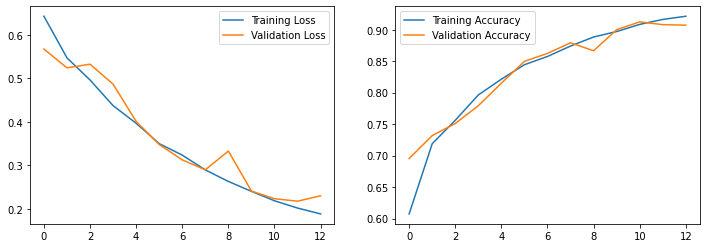

In [84]:
losses = h2.history['loss']
accs = h2.history['accuracy']
val_losses = h2.history['val_loss']
val_accs = h2.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# Testing
import matplotlib.image as mpimg
probabilities = model_sample.predict(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

In [20]:
%%time
model = tf.keras.models.load_model('model_11.h5')

Wall time: 1.96 s


y = 0.4713953, your algorithm predicts a :cat
Wall time: 179 ms


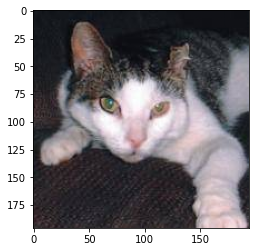

In [17]:
%%time

my_image = "9156.jpg" 

fname = "cats-dogs/test1/" + my_image
image = np.array(mpimg.imread(fname))
image = image/255.
my_image = np.resize(image,(200,200,3)).reshape((1,200,200,3))
pred = model.predict(my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(pred)) + ", your algorithm predicts a :" + get_class(pred))

y = 0.6573744, your algorithm predicts a :dog
Wall time: 183 ms


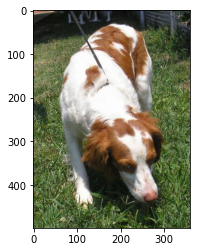

In [18]:
%%time

my_image = "7000.jpg" 

fname = "cats-dogs/test1/" + my_image
image = np.array(mpimg.imread(fname))
image = image/255.
my_image = np.resize(image,(200,200,3)).reshape((1,200,200,3))
pred = model.predict(my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(pred)) + ", your algorithm predicts a :" + get_class(pred))

In [16]:
def get_class(pred):
    if pred>0.5:
        return "dog"
    else:
        return "cat"